# PTB-XL（records100 子文件夹逐个扫描）→ NumPy 预处理 Notebook

本 Notebook **按子文件夹逐个扫描** `records100/00000、01000、...`，
在每个子文件夹中把同名的 `*_lr.hea` 与 `*_lr.dat` 成对配好，
用 **WFDB** 读取后逐条保存为 `.npy`（可选 z‑score 与统一长度）。
最后可选把所有样本堆叠成 `X.npy`。

## 0. 安装依赖（如已安装可跳过）

In [1]:
%pip install -q wfdb numpy

Note: you may need to restart the kernel to use updated packages.


## 1. 路径与参数（请改为你的本地路径）

In [2]:
from pathlib import Path

# 必须正好指向 records100 这一层
RECORDS_ROOT = Path("../data/ptb_xl_ecg/records100")

# 输出目录（会自动创建）
OUT_DIR = Path("../processed_records100_by_folder")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 选项
LR_ONLY     = True     # 只处理 *_lr.hea/.dat（推荐 True）
STANDARDIZE = True     # 逐导联 z-score
TARGET_LEN  = 1000     # 统一长度（100Hz×10s）；设 0 表示不裁剪/填充
SKIP_EXISTS = True     # 已存在 .npy 则跳过
LIMIT_FOLDERS = None   # 仅处理前K个子文件夹（调试用）；None=全部
LIMIT_FILES_PER_FOLDER = None  # 每个子文件夹只处理前N对（调试用）

print("RECORDS_ROOT =", RECORDS_ROOT)
print("OUT_DIR      =", OUT_DIR)

RECORDS_ROOT = ../data/ptb_xl_ecg/records100
OUT_DIR      = ../processed_records100_by_folder


## 2. 工具函数

In [3]:
import numpy as np

def zscore_per_channel(x: np.ndarray) -> np.ndarray:
    m = x.mean(axis=0, keepdims=True)
    s = x.std(axis=0, keepdims=True)
    s[s == 0] = 1.0
    return (x - m) / s

def pad_or_crop(x: np.ndarray, L: int) -> np.ndarray:
    if L <= 0:
        return x
    T, C = x.shape
    if T == L:
        return x
    if T > L:
        return x[:L, :]
    y = np.zeros((L, C), dtype=x.dtype)
    y[:T, :] = x
    return y

## 3. 逐个子文件夹扫描与配对（只列不读）

In [4]:
from pathlib import Path

# 列出 records100 下的一级子文件夹
subdirs = sorted([p for p in RECORDS_ROOT.iterdir() if p.is_dir()])
if LIMIT_FOLDERS:
    subdirs = subdirs[:int(LIMIT_FOLDERS)]

print("子文件夹个数:", len(subdirs))
print("示例前10个：", [d.name for d in subdirs[:10]])

# 在每个子文件夹里配对 *_lr.hea 与 .dat
pairs_by_folder = {}
total_pairs = 0

for folder in subdirs:
    heas = sorted(folder.glob("*_lr.hea") if LR_ONLY else folder.glob("*.hea"))
    pairs = []
    for hea in heas:
        dat = hea.with_suffix(".dat")
        # 兼容大小写 .DAT
        if not dat.exists():
            dat_upper = hea.with_suffix(".DAT")
            if dat_upper.exists():
                dat = dat_upper
        if dat.exists():
            pairs.append((hea, dat))
    if LIMIT_FILES_PER_FOLDER:
        pairs = pairs[:int(LIMIT_FILES_PER_FOLDER)]
    pairs_by_folder[folder] = pairs
    total_pairs += len(pairs)

print("总配对数量:", total_pairs)
# 展示第一个子文件夹前几对
for folder in subdirs[:1]:
    print(f"\n[{folder.name}] 前几对：")
    for hea, dat in pairs_by_folder[folder][:8]:
        print(" -", hea.name, "|", dat.name)

子文件夹个数: 22
示例前10个： ['00000', '01000', '02000', '03000', '04000', '05000', '06000', '07000', '08000', '09000']
总配对数量: 21837

[00000] 前几对：
 - 00001_lr.hea | 00001_lr.dat
 - 00002_lr.hea | 00002_lr.dat
 - 00003_lr.hea | 00003_lr.dat
 - 00004_lr.hea | 00004_lr.dat
 - 00005_lr.hea | 00005_lr.dat
 - 00006_lr.hea | 00006_lr.dat
 - 00007_lr.hea | 00007_lr.dat
 - 00008_lr.hea | 00008_lr.dat


## 4. 读取→处理→保存为 `.npy` + `.json`（按子文件夹逐个执行）

In [5]:
import json, wfdb, numpy as np

ok = skip = fail = 0

for folder in subdirs:
    pairs = pairs_by_folder.get(folder, [])
    if not pairs:
        continue

    print(f"\n处理子文件夹：{folder.name} | 记录数：{len(pairs)}")
    for hea, dat in pairs:
        base = hea.with_suffix("")  # 去掉扩展名 -> /.../00000/00001_lr
        out_npy  = OUT_DIR / f"{base.name}.npy"
        out_json = OUT_DIR / f"{base.name}.json"

        if SKIP_EXISTS and out_npy.exists():
            skip += 1
            continue

        try:
            rec = wfdb.rdrecord(str(base))                # 传“基名”，不带扩展名
            sig = rec.p_signal.astype(np.float32, copy=False)  # (T, C)，单位 mV

            if STANDARDIZE:
                sig = zscore_per_channel(sig)
            if TARGET_LEN > 0:
                sig = pad_or_crop(sig, TARGET_LEN)

            np.save(out_npy, sig)

            meta = dict(
                fs=float(rec.fs),
                n_sig=int(sig.shape[1]),
                n_samples=int(sig.shape[0]),
                sig_names=list(rec.sig_name),
                record_base=str(base),
                sampling_rate_declared=100
            )
            out_json.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")
            ok += 1
        except Exception as e:
            fail += 1
            print(f"[失败] {base.name}: {e}")

print(f"\n✅ 完成：成功 {ok}，跳过 {skip}，失败 {fail}。输出目录：{OUT_DIR}")


处理子文件夹：00000 | 记录数：999

处理子文件夹：01000 | 记录数：1000

处理子文件夹：02000 | 记录数：1000

处理子文件夹：03000 | 记录数：1000

处理子文件夹：04000 | 记录数：1000

处理子文件夹：05000 | 记录数：1000

处理子文件夹：06000 | 记录数：1000

处理子文件夹：07000 | 记录数：1000

处理子文件夹：08000 | 记录数：1000

处理子文件夹：09000 | 记录数：1000

处理子文件夹：10000 | 记录数：1000

处理子文件夹：11000 | 记录数：1000

处理子文件夹：12000 | 记录数：1000

处理子文件夹：13000 | 记录数：1000

处理子文件夹：14000 | 记录数：1000

处理子文件夹：15000 | 记录数：1000

处理子文件夹：16000 | 记录数：1000

处理子文件夹：17000 | 记录数：1000

处理子文件夹：18000 | 记录数：1000

处理子文件夹：19000 | 记录数：1000

处理子文件夹：20000 | 记录数：1000

处理子文件夹：21000 | 记录数：838

✅ 完成：成功 21837，跳过 0，失败 0。输出目录：../processed_records100_by_folder


## 5. （可选）堆叠所有样本为 `X.npy`（要求长度一致，如 TARGET_LEN=1000）

In [6]:
import numpy as np

npys = sorted(OUT_DIR.glob("*.npy"))
if not npys:
    raise FileNotFoundError("没有找到任何 .npy，请先运行第 4 步。")

# 简单检查长度一致性
lengths = set()
for p in npys[:50]:  # 采样检查前50个
    arr = np.load(p, mmap_mode="r")
    lengths.add(arr.shape[0])
    if len(lengths) > 1:
        break

if len(lengths) > 1:
    print("样本长度不一致，无法堆叠。请将 TARGET_LEN 设为固定值（如 1000）后重新生成。")
else:
    X = np.stack([np.load(p) for p in npys], axis=0).astype(np.float32, copy=False)
    np.save(OUT_DIR / "X.npy", X)
    print("已保存 X.npy，形状 =", X.shape)

已保存 X.npy，形状 = (21837, 1000, 12)


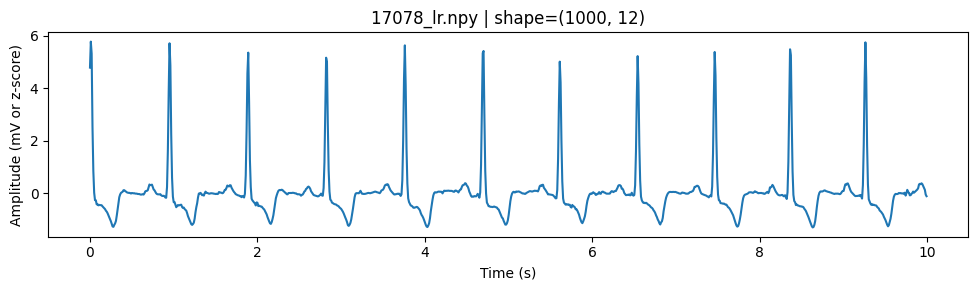

In [9]:
from pathlib import Path
import json, random
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = Path("../data/processed_records100_by_folder")  # 改成你的输出目录

npys = sorted(OUT_DIR.glob("*.npy"))
assert npys, "目录里还没有 .npy"

p = random.choice(npys)                   # 也可写成 p = OUT_DIR/'00001_lr.npy'
x = np.load(p)                            # 形状 (T, C)
meta = json.loads((p.with_suffix(".json")).read_text(encoding="utf-8"))
fs = float(meta.get("fs", 100.0))
t = np.arange(x.shape[0]) / fs

plt.figure(figsize=(10,3))
plt.plot(t, x[:,0])
plt.title(f"{p.name} | shape={x.shape}")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude (mV or z-score)")
plt.tight_layout(); plt.show()